In [31]:
import tensorflow as tf
from tensorflow import keras
import os 
import zipfile
import numpy as np
import cv2
import random
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import h5py

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

import datetime as dt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [32]:
# Set random seeds
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [33]:
print(tf.test.is_built_with_cuda())
len(tf.config.experimental.list_physical_devices('GPU'))

True


1

In [34]:
main_dir = "Shop DataSet"

In [35]:
shoplifter_dir = os.path.join(main_dir, 'shop lifters')
non_shoplifter_dir = os.path.join(main_dir, 'non shop lifters')

In [36]:
for dir, dirname, filename in os.walk(main_dir):
  print(f"Found {len(dirname)} directories and {len(filename)} images in {dir}")

Found 2 directories and 0 images in Shop DataSet
Found 0 directories and 531 images in Shop DataSet\non shop lifters
Found 0 directories and 324 images in Shop DataSet\shop lifters


In [37]:
SEQUENCE_LENGTH = 20
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
BATCH_SIZE = 2

In [38]:
def load_frames(path, n_frames, frame_step, size):
    result = []
    src = cv2.VideoCapture(str(path))
    
    video_length = int(src.get(cv2.CAP_PROP_FRAME_COUNT))
    need_length = 1 + (n_frames - 1) * frame_step
    
    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)
        
    # Set starting frame
    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    
    # Read first frame
    ret, frame = src.read()
    if ret:
        frame = cv2.resize(frame, size)  # Resize frame to desired size
        result.append(format_frame(frame, size))
    
    # Read subsequent frames
    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = cv2.resize(frame, size)  # Resize each frame
            result.append(format_frame(frame, size))
        else:
            # If there's an issue with the frame, append a black frame
            result.append(np.zeros_like(result[0]))
    
    src.release()

    # Convert to RGB as cv2 reads in BGR
    result = np.array(result)[..., [2, 1, 0]]
    return result

In [39]:
def format_frame(frame, size):
    """Normalize the frame and convert to float16."""
    frame = tf.convert_to_tensor(frame, dtype=tf.float32) / 255.0  # Normalize to [0, 1]
    return frame

In [40]:
import matplotlib.animation as animation

def plot_vid(images):
    fig = plt.figure()
    frames = []
    
    for img in images:
        frame_plot = plt.imshow(img, animated=True)  # Directly use the image as is
        frames.append([frame_plot])

    ani = animation.ArtistAnimation(fig, frames, interval=500, blit=True, repeat_delay=1000)
    
    # Save as MP4 using ffmpeg
    ani.save('movie.mp4', writer='ffmpeg')
    plt.show()

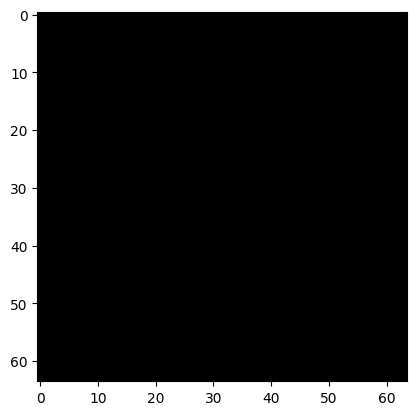

In [41]:
frames = load_frames("Shop DataSet\shop lifters\shop_lifter_0.mp4",SEQUENCE_LENGTH,20,size=(IMAGE_HEIGHT,IMAGE_WIDTH))
plot_vid(frames)

In [42]:
frames.shape

(20, 64, 64, 3)

## save the picked frames

In [43]:
# data = []
# labels = []
# for path in os.listdir(shoplifter_dir):
#     frames = load_frames(shoplifter_dir + '/' +path,SEQUENCE_LENGTH,10,size=(IMAGE_HEIGHT,IMAGE_WIDTH))
#     data.append(frames)
#     labels.append(1)
#     print(path + ": done")
# for path in os.listdir(non_shoplifter_dir):
#     frames = load_frames(non_shoplifter_dir + '/' + path,SEQUENCE_LENGTH,10,size=(IMAGE_HEIGHT,IMAGE_WIDTH))
#     data.append(frames)
#     labels.append(0)
#     print(path + ": done")

In [44]:
# import numpy as np

# # Convert lists to NumPy arrays
# data_array = np.array(data)
# labels_array = np.array(labels)

# # Save to HDF5 file
# with h5py.File('dataset.h5', 'w') as hf:
#     hf.create_dataset('data', data=data_array)
#     hf.create_dataset('labels', data=labels_array)

In [45]:
# Load from HDF5 file
with h5py.File('dataset.h5', 'r') as hf:
    data = np.array(hf['data'])
    labels = np.array(hf['labels'])

In [46]:
import numpy as np
from sklearn.model_selection import train_test_split

# Convert lists to NumPy arrays if not already done
data = np.array(data)
labels = np.array(labels)

# Split data into training (70%) and temp (30%)
data_train, data_temp, labels_train, labels_temp = train_test_split(
    data, labels, test_size=0.3, random_state=42, stratify=labels)

# Split the temp data into validation (50% of temp = 15% of original) and test (50% of temp = 15% of original)
data_val, data_test, labels_val, labels_test = train_test_split(
    data_temp, labels_temp, test_size=0.5, random_state=42, stratify=labels_temp)

# Print shapes to verify
print("Training data shape:", data_train.shape)
print("Validation data shape:", data_val.shape)
print("Test data shape:", data_test.shape)

Training data shape: (598, 20, 64, 64, 3)
Validation data shape: (128, 20, 64, 64, 3)
Test data shape: (129, 20, 64, 64, 3)


In [47]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

In [50]:
from sklearn.utils import class_weight
import numpy as np

# Assuming labels are in a NumPy array (after splitting the dataset)
labels_train = np.array(labels_train)  # Ensure labels are NumPy array

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',  # Set to 'balanced' to adjust for class imbalance
    classes=np.unique(labels_train),  # The unique classes (e.g., [0, 1])
    y=labels_train  # The labels for training data
)

# Create a dictionary mapping class to weight
class_weight_dict = dict(zip(np.unique(labels_train), class_weights))

# Print class weights
print("Class weights:", class_weight_dict)

Class weights: {0: 0.8059299191374663, 1: 1.3171806167400881}


In [51]:
# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',   # Metric to monitor
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored metric
)

In [52]:
# ReduceLROnPlateau: Reduce the learning rate when the metric has stopped improving.
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   # Metric to monitor
    factor=0.5,           # Factor by which the learning rate will be reduced
    patience=3,           # Number of epochs with no improvement to wait before reducing the learning rate
    min_lr=1e-6           # Lower bound on the learning rate
)

In [53]:
# ModelCheckpoint: Save the model after every epoch.
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',       # Filepath to save the model
    monitor='val_loss',     # Metric to monitor
    save_best_only=True,    # Only save the best model
    save_weights_only=True  # Only save the model's weights
)

# models

## ConvLSTM

In [48]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(1, activation = "sigmoid"))
    
    ########################################################################################################################
     
    # Compile the model and specify loss function, optimizer and metrics values to the model
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])    
        
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [49]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_4 (ConvLSTM2D)  (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 20, 31, 31, 4)    0         
 3D)                                                             
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 31, 31, 4)    0         
 tributed)                                                       
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                      

In [ ]:
# Start training the model.
convlstm_model_training_history = convlstm_model.fit(
    x = data_train, 
    y = labels_train, 
    epochs = 50, 
    batch_size = BATCH_SIZE,
    shuffle = True, 
    validation_data = (data_val, labels_val),  # Use explicit validation data
    class_weight = class_weight_dict,
    callbacks = [early_stopping, reduce_lr_on_plateau, checkpoint]
)

In [ ]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(data_test, labels_test)

In [ ]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

In [ ]:
# Define a name
model_file_name = f'convlstm_model_0.h5'

# Save your Model.
convlstm_model.save(model_file_name)

## Transformers

In [54]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [55]:
def positional_encoding(max_len, d_model):
    pos = tf.range(max_len, dtype=tf.float32)[:, tf.newaxis]  # Shape (max_len, 1)
    i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :]    # Shape (1, d_model)
    angle_rates = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))

    pos_encoding = pos * angle_rates  # Shape (max_len, d_model)

    # Calculate sine and cosine
    pos_encoding_sin = tf.sin(pos_encoding[:, 0::2])  # Sine for even indices
    pos_encoding_cos = tf.cos(pos_encoding[:, 1::2])  # Cosine for odd indices

    # Combine sine and cosine into one tensor
    pos_encoding_final = tf.concat([pos_encoding_sin, pos_encoding_cos], axis=-1)  # Shape (max_len, d_model)

    return pos_encoding_final  # Return without adding new axis


In [56]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = models.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, training):
        attn_output = self.mha(x, x)
        out1 = self.layernorm1(x + self.dropout1(attn_output, training=training))
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + self.dropout2(ffn_output, training=training))

In [57]:
def create_video_transformer(num_classes, input_shape, d_model=128, num_heads=4, dff=512, num_layers=4):
    inputs = layers.Input(shape=input_shape)  # Shape: (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    
    # Convolutional Layer to Reduce Dimensions
    x = layers.Conv2D(d_model, kernel_size=3, strides=2, padding='same')(inputs)  # Shape: (SEQUENCE_LENGTH, NEW_HEIGHT, NEW_WIDTH, d_model)
    
    # Reshape to (SEQUENCE_LENGTH, -1, d_model) for Transformer
    x = layers.Reshape((input_shape[0], -1, d_model))(x)  # Shape: (SEQUENCE_LENGTH, NEW_HEIGHT * NEW_WIDTH, d_model)

    # Calculate Positional Encoding
    pos_encoding = positional_encoding(input_shape[0], d_model)  # Shape: (SEQUENCE_LENGTH, d_model)

    # Reshape pos_encoding to match x's shape for broadcasting
    pos_encoding = tf.expand_dims(pos_encoding, axis=0)  # Shape: (1, SEQUENCE_LENGTH, d_model)
    pos_encoding = tf.tile(pos_encoding, [tf.shape(x)[0], 1, 1])  # Now shape is (batch_size, SEQUENCE_LENGTH, d_model)
    
    # Expand the dimensions of pos_encoding to match the spatial dimensions of x
    pos_encoding = tf.expand_dims(pos_encoding, axis=2)  # Shape: (batch_size, SEQUENCE_LENGTH, 1, d_model)
    pos_encoding = tf.tile(pos_encoding, [1, 1, tf.shape(x)[2], 1])  # Shape: (batch_size, SEQUENCE_LENGTH, NEW_HEIGHT * NEW_WIDTH, d_model)

    x += pos_encoding  # This should now work

    # Transformer Layers
    for _ in range(num_layers):
        x = TransformerEncoder(d_model, num_heads, dff)(x)

    # Final Layer
    x = layers.GlobalAveragePooling2D()(x)  # Global average pooling
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Output layer

    return tf.keras.Model(inputs, outputs)

In [58]:
# Define parameters
num_classes = 2  # Adjust based on your dataset
input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)  # Change based on your data

# Create the model
video_transformer = create_video_transformer(num_classes, input_shape)

# Compile and train the model
video_transformer.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with reduced batch size
video_transformer.fit(data_train,
                      labels_train,
                      epochs=50,
                      batch_size=BATCH_SIZE,
                      validation_data=(data_val, labels_val),
                      class_weight=class_weight_dict,
                      callbacks=[early_stopping, reduce_lr_on_plateau, checkpoint])

Epoch 1/50


ResourceExhaustedError: Graph execution error:

Detected at node 'model_1/transformer_encoder_4/multi_head_attention_4/einsum/Einsum' defined at (most recent call last):
    File "D:\anaconda3\envs\tensor\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "D:\anaconda3\envs\tensor\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "D:\anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "D:\anaconda3\envs\tensor\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "D:\anaconda3\envs\tensor\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "D:\anaconda3\envs\tensor\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "D:\anaconda3\envs\tensor\lib\asyncio\windows_events.py", line 321, in run_forever
      super().run_forever()
    File "D:\anaconda3\envs\tensor\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "D:\anaconda3\envs\tensor\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "D:\anaconda3\envs\tensor\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\anaconda3\envs\tensor\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "D:\anaconda3\envs\tensor\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "D:\anaconda3\envs\tensor\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "D:\anaconda3\envs\tensor\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "D:\anaconda3\envs\tensor\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "D:\anaconda3\envs\tensor\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\anaconda3\envs\tensor\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "D:\anaconda3\envs\tensor\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "D:\anaconda3\envs\tensor\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\anaconda3\envs\tensor\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\anaconda3\envs\tensor\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\anaconda3\envs\tensor\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\AbuAlHagag\AppData\Local\Temp\ipykernel_18736\3589033235.py", line 12, in <module>
      video_transformer.fit(data_train,
    File "D:\anaconda3\envs\tensor\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda3\envs\tensor\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "D:\anaconda3\envs\tensor\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "D:\anaconda3\envs\tensor\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\anaconda3\envs\tensor\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "D:\anaconda3\envs\tensor\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "D:\anaconda3\envs\tensor\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda3\envs\tensor\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "D:\anaconda3\envs\tensor\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda3\envs\tensor\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\anaconda3\envs\tensor\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda3\envs\tensor\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "D:\anaconda3\envs\tensor\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "D:\anaconda3\envs\tensor\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda3\envs\tensor\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\anaconda3\envs\tensor\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\AbuAlHagag\AppData\Local\Temp\ipykernel_18736\3230239993.py", line 15, in call
      attn_output = self.mha(x, x)
    File "D:\anaconda3\envs\tensor\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda3\envs\tensor\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\anaconda3\envs\tensor\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "D:\anaconda3\envs\tensor\lib\site-packages\keras\layers\attention\multi_head_attention.py", line 596, in call
      attention_output, attention_scores = self._compute_attention(
    File "D:\anaconda3\envs\tensor\lib\site-packages\keras\layers\attention\multi_head_attention.py", line 525, in _compute_attention
      attention_scores = tf.einsum(self._dot_product_equation, key, query)
Node: 'model_1/transformer_encoder_4/multi_head_attention_4/einsum/Einsum'
OOM when allocating tensor with shape[2,4,20480,20480] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_1/transformer_encoder_4/multi_head_attention_4/einsum/Einsum}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_15796]

# more models examples

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(128))
                                      
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))    
    model.add(Dense(1, activation = 'sigmoid'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [ ]:
def create_resnet_video_model(input_shape, sequence_length):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    model = Sequential()

    model.add(TimeDistributed(base_model, input_shape=(sequence_length,) + input_shape))

    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    model.add(TimeDistributed(Flatten()))
    
    model.add(LSTM(512, return_sequences=False))
    
    
    
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    return model